In [ ]:
!pip install gdown
!gdown --id 1_9NPC8E-kt4pU6rTi5lkh91eFR_jnFav --output sino_nom.zip
!unzip -u 'sino_nom.zip'

In [ ]:
!pip install numpy-stl

In [1]:
g_path = 'wb_2D3Dretrieval_dataset/pairs'

In [2]:
import numpy as np
from stl import mesh
import os
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import io
import cv2

img_size = (256, 256) # (512, 512)
def crop(image):
    contours, hierarchy = cv2.findContours(image ,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    cropped_image = None

    min_x = min_y = float('inf')
    max_x = max_y = 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if x==0 or y==0:
            continue
        # Tìm tọa độ min-max
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_x = max(max_x, x + w)
        max_y = max(max_y, y + h)
    return cv2.resize(image[min_y:max_y, min_x:max_x], img_size)  

def stl_to_2d(file_path):
    # Load the STL file
    _mesh = mesh.Mesh.from_file(file_path)
    # Compute the bounding box
    min_coords = np.min(_mesh.points, axis=0)
    max_coords = np.max(_mesh.points, axis=0)
    # Choose a cutting axis (e.g., the z-axis)
    cutting_axis = 2  # Assuming z-axis, change if needed
    # Find the coordinate value halfway between the minimum and maximum along the cutting axis
    cutting_plane = min_coords[cutting_axis] + 6*(max_coords[cutting_axis] - min_coords[cutting_axis]) / 7.0
    # Partition the model based on the cutting plane
    vectors_above_plane = []
    for vector in _mesh.vectors:
        # Check if all vertices of the triangle are above the cutting plane
        if np.all(vector[:, cutting_axis] > cutting_plane):
            vectors_above_plane.append(vector)
    # Create a new mesh object from the vectors above the cutting plane
    above_cutting_plane_mesh = mesh.Mesh(np.zeros(len(vectors_above_plane), dtype=mesh.Mesh.dtype))
    above_cutting_plane_mesh.vectors = vectors_above_plane

    figure = plt.figure()
    axes = figure.add_subplot(projection='3d')
    axes.view_init(elev=90, azim=-90)
    # Load the STL files and add the vectors to the plot
    poly_collection = mplot3d.art3d.Poly3DCollection(above_cutting_plane_mesh.vectors)
    poly_collection.set_color((0,0,0))  # play with color
    scale = above_cutting_plane_mesh.points.flatten()
    axes.auto_scale_xyz(scale, scale, scale)
    axes.add_collection3d(poly_collection)
    plt.grid(False)
    plt.axis('off')
    # Show the plot to the screen
    buffer = io.BytesIO()
    figure.savefig(buffer, format='jpg')
    buffer.seek(0)
    image_buffer = cv2.imdecode(np.frombuffer(buffer.getvalue(), dtype=np.uint8), -1)
    gray = cv2.cvtColor(image_buffer, cv2.COLOR_BGR2GRAY)
    ret,thresh_3d = cv2.threshold(gray,150,255,0)
    image_ = crop(thresh_3d)
    buffer.close()
    plt.close()
    return image_
    

(<matplotlib.image.AxesImage at 0x1f36ec32890>, (-0.5, 255.5, 255.5, -0.5))

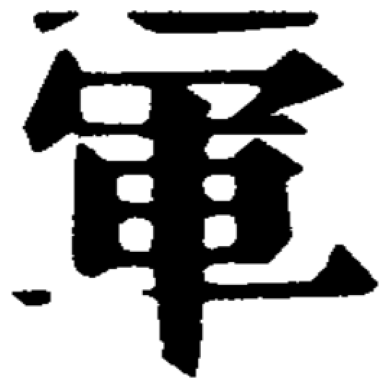

In [26]:
plt.imshow(stl_to_2d('wb_2D3Dretrieval_dataset/pairs/stl/112.stl'), cmap = 'gray'), plt.axis('off')

In [3]:

stl_path = os.path.join(g_path,'stl') 
stl_2d_path = os.path.join(g_path,'stl_to_2d_pairs')
if not os.path.exists(stl_2d_path):
    os.mkdir(stl_2d_path) 
index=1
num_file= len(os.listdir(stl_path))
for file in os.listdir(stl_path): 
    print(f'{index}/{num_file}')
    index+=1
    path = os.path.join(stl_path,file)
    img_2d = stl_to_2d(path)
    out_path = os.path.join(stl_2d_path,file+'.png') 
    cv2.imwrite(out_path, img_2d)

1/228
2/228
3/228
4/228
5/228
6/228
7/228
8/228
9/228
10/228
11/228
12/228
13/228
14/228
15/228
16/228
17/228
18/228
19/228
20/228
21/228
22/228
23/228
24/228
25/228
26/228
27/228
28/228
29/228
30/228
31/228
32/228
33/228
34/228
35/228
36/228
37/228
38/228
39/228
40/228
41/228
42/228
43/228
44/228
45/228
46/228
47/228
48/228
49/228
50/228
51/228
52/228
53/228
54/228
55/228
56/228
57/228
58/228
59/228
60/228
61/228
62/228
63/228
64/228
65/228
66/228
67/228
68/228
69/228
70/228
71/228
72/228
73/228
74/228
75/228
76/228
77/228
78/228
79/228
80/228
81/228
82/228
83/228
84/228
85/228
86/228
87/228
88/228
89/228
90/228
91/228
92/228
93/228
94/228
95/228
96/228
97/228
98/228
99/228
100/228
101/228
102/228
103/228
104/228
105/228
106/228
107/228
108/228
109/228
110/228
111/228
112/228
113/228
114/228
115/228
116/228
117/228
118/228
119/228
120/228
121/228
122/228
123/228
124/228
125/228
126/228
127/228
128/228
129/228
130/228
131/228
132/228
133/228
134/228
135/228
136/228
137/228
138/228
139/

In [3]:
# Process 2d images
def process_2d(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh_2d = cv2.threshold(gray,150,255,0)
    return crop(thresh_2d)

In [21]:
from skimage.feature import hog
from skimage import exposure
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def feature_matching_HOG_similarity(image1, image2):
    # Feature 1
    features1, hog_image1 = hog(image1, orientations=9, pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2), visualize=True)

    # Feature 2
    features2, hog_image2 = hog(image2, orientations=9, pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2), visualize=True)

    # features1 = exposure.rescale_intensity(features1, in_range=(0, 10))
    # features2 = exposure.rescale_intensity(features2, in_range=(0, 10))

    # Reshape vectors
    features1 = features1.reshape(1, -1)
    features2 = features2.reshape(1, -1)

    # Similarity
    similarity = cosine_similarity(features1, features2)

    return similarity

def feature_hog(image):
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2), visualize=True)
    
    # features = exposure.rescale_intensity(features, in_range=(0, 10))
    
    features = features.reshape(1, -1)
    
    return features

def feature_matching_HOG(features1, features2):
    similarity = cosine_similarity(features1, features2)

    return similarity


In [17]:
stl_path = os.path.join(g_path,'stl') 
stl_2d_path = os.path.join(g_path,'stl_to_2d_pairs')
num_file= len(os.listdir(stl_path))

In [7]:
num_file

228

In [18]:
# Create the label csv file
f = open("wb_2D3Dretrieval_dataset/pairs/labels_pairs.csv", "w") # test_hog_512.csv

queries_path =  os.path.join(g_path,'print') 

num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    f.write(filename + ',"' + filename.replace("png", "stl") + '"' +'\n')
f.close()

In [19]:
stl_2d_hog = []
binary_images_stl_2d_folder = os.path.join(g_path,'stl_to_2d_pairs')
for filename in os.listdir(binary_images_stl_2d_folder):
        image_path = os.path.join(binary_images_stl_2d_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        features = feature_hog(image)
        stl_2d_hog.append((filename, features))
        

In [10]:
stl_2d_hog[0][0]

'0.stl.png'

In [9]:
stl_2d_hog[0][1].shape

(1, 34596)

In [10]:
print(stl_2d_hog[0][1].sum())
print(stl_2d_hog[0][1].max())
print(stl_2d_hog[0][1].min())

1557.925498542314
0.9999999987499999
0.0


In [11]:
for filename, stl_2d_hog_feature in stl_2d_hog:
    print(filename, stl_2d_hog_feature.shape)

0.stl.png (1, 34596)
1.stl.png (1, 34596)
10.stl.png (1, 34596)
100.stl.png (1, 34596)
101.stl.png (1, 34596)
102.stl.png (1, 34596)
103.stl.png (1, 34596)
104.stl.png (1, 34596)
105.stl.png (1, 34596)
106.stl.png (1, 34596)
107.stl.png (1, 34596)
108.stl.png (1, 34596)
109.stl.png (1, 34596)
11.stl.png (1, 34596)
110.stl.png (1, 34596)
111.stl.png (1, 34596)
112.stl.png (1, 34596)
113.stl.png (1, 34596)
114.stl.png (1, 34596)
115.stl.png (1, 34596)
116.stl.png (1, 34596)
117.stl.png (1, 34596)
118.stl.png (1, 34596)
119.stl.png (1, 34596)
12.stl.png (1, 34596)
120.stl.png (1, 34596)
121.stl.png (1, 34596)
122.stl.png (1, 34596)
123.stl.png (1, 34596)
124.stl.png (1, 34596)
125.stl.png (1, 34596)
126.stl.png (1, 34596)
127.stl.png (1, 34596)
128.stl.png (1, 34596)
129.stl.png (1, 34596)
13.stl.png (1, 34596)
130.stl.png (1, 34596)
131.stl.png (1, 34596)
132.stl.png (1, 34596)
133.stl.png (1, 34596)
134.stl.png (1, 34596)
135.stl.png (1, 34596)
136.stl.png (1, 34596)
137.stl.png (1, 345

In [31]:
def find_similar_HOG(img_path, stl_2d_hog):
    input_image = process_2d(cv2.imread(img_path))
    binary_images_folder = stl_2d_path
    image_matches = []
    
    input_image_feature = feature_hog(input_image)
    
    for filename, stl_2d_hog_feature in stl_2d_hog:
        # Cosin similarity
        match = feature_matching_HOG(stl_2d_hog_feature, input_image_feature)
        image_matches.append((filename, match.max()))

    sorted_images = sorted(image_matches, key=lambda x: x[1], reverse=True)
    top_5 = [path for path, match_value in sorted_images[:5]]
    return top_5

In [32]:
f = open("wb_2D3Dretrieval_dataset/pairs/test_hog.csv", "w") # test_hog_512.csv
f.write('query,label\n')
print(g_path)
queries_path =  os.path.join(g_path,'print') 
index = 1
num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    print(f'{index}/{num_file}')
    index+=1
    img_path = os.path.join(queries_path,filename) 
    top5 = find_similar_HOG(img_path, stl_2d_hog)
    top5_tostring = ','.join([n[:-4] for n in top5])
    f.write(filename + ',"' + top5_tostring +'"'+'\n' )
f.close()

wb_2D3Dretrieval_dataset/pairs
1/228
2/228
3/228
4/228
5/228
6/228
7/228
8/228
9/228
10/228
11/228
12/228
13/228
14/228
15/228
16/228
17/228
18/228
19/228
20/228
21/228
22/228
23/228
24/228
25/228
26/228
27/228
28/228
29/228
30/228
31/228
32/228
33/228
34/228
35/228
36/228
37/228
38/228
39/228
40/228
41/228
42/228
43/228
44/228
45/228
46/228
47/228
48/228
49/228
50/228
51/228
52/228
53/228
54/228
55/228
56/228
57/228
58/228
59/228
60/228
61/228
62/228
63/228
64/228
65/228
66/228
67/228
68/228
69/228
70/228
71/228
72/228
73/228
74/228
75/228
76/228
77/228
78/228
79/228
80/228
81/228
82/228
83/228
84/228
85/228
86/228
87/228
88/228
89/228
90/228
91/228
92/228
93/228
94/228
95/228
96/228
97/228
98/228
99/228
100/228
101/228
102/228
103/228
104/228
105/228
106/228
107/228
108/228
109/228
110/228
111/228
112/228
113/228
114/228
115/228
116/228
117/228
118/228
119/228
120/228
121/228
122/228
123/228
124/228
125/228
126/228
127/228
128/228
129/228
130/228
131/228
132/228
133/228
134/228
135/2

In [33]:
# Visualize the results
def visualize_results(img_file_name):
    
    # Visualize the results
    queries_path =  os.path.join(g_path,'print') 
    img1_path = os.path.join(queries_path, img_file_name)

    img1_process = process_2d(cv2.imread(img1_path))
    
    # Print the directory
    top_5 = find_similar_HOG(img1_path, stl_2d_hog)
    for image_path in top_5:
        print(image_path)
        
    # Final results
    img2d_path = [os.path.join(stl_2d_path,p) for p in top_5]
    
    # Visualize
    img2d = [cv2.imread(os.path.join(stl_2d_path,p)) for p in top_5]
    plt.subplot(161),plt.imshow(process_2d(cv2.imread(img1_path)),cmap = 'gray'),plt.title('2D')
    plt.axis('off')
    plt.subplot(162),plt.imshow(img2d[0]),plt.title(top_5[0][:-8])
    plt.axis('off')
    plt.subplot(163),plt.imshow(img2d[1]),plt.title(top_5[1][:-8])
    plt.axis('off')
    plt.subplot(164),plt.imshow(img2d[2]),plt.title(top_5[2][:-8])
    plt.axis('off')
    plt.subplot(165), plt.imshow(img2d[3]),plt.title(top_5[3][:-8])
    plt.axis('off')
    plt.subplot(166),plt.imshow(img2d[4]),plt.title(top_5[4][:-8])
    plt.axis('off')
    plt.show()
        

18.stl.png
14.stl.png
62.stl.png
49.stl.png
21.stl.png


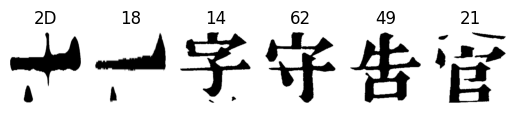

In [34]:
visualize_results("18.png")

In [35]:
# Visualize the results
img_file_name = '18.png' # 139, 32, ..
img1_path = os.path.join(queries_path, img_file_name)

img1_process = process_2d(cv2.imread(img1_path))
# In ra đường dẫn của 5 ảnh tương tự nhất
top_5 = find_similar_HOG(img1_path, stl_2d_hog)
for image_path in top_5:
    print(image_path)

18.stl.png
14.stl.png
62.stl.png
49.stl.png
21.stl.png


In [36]:
# Final results
img2d_path = [os.path.join(stl_2d_path,p) for p in top_5]
img2d_path

['wb_2D3Dretrieval_dataset/pairs\\stl_to_2d_pairs\\18.stl.png',
 'wb_2D3Dretrieval_dataset/pairs\\stl_to_2d_pairs\\14.stl.png',
 'wb_2D3Dretrieval_dataset/pairs\\stl_to_2d_pairs\\62.stl.png',
 'wb_2D3Dretrieval_dataset/pairs\\stl_to_2d_pairs\\49.stl.png',
 'wb_2D3Dretrieval_dataset/pairs\\stl_to_2d_pairs\\21.stl.png']

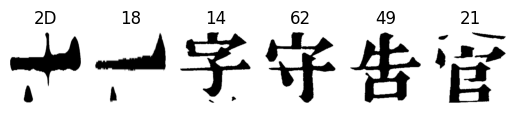

In [37]:
# Final results
img2d = [cv2.imread(os.path.join(stl_2d_path,p)) for p in top_5]
plt.subplot(161),plt.imshow(process_2d(cv2.imread(img1_path)),cmap = 'gray'),plt.title('2D')
plt.axis('off')
plt.subplot(162),plt.imshow(img2d[0]),plt.title(top_5[0][:-8])
plt.axis('off')
plt.subplot(163),plt.imshow(img2d[1]),plt.title(top_5[1][:-8])
plt.axis('off')
plt.subplot(164),plt.imshow(img2d[2]),plt.title(top_5[2][:-8])
plt.axis('off')
plt.subplot(165), plt.imshow(img2d[3]),plt.title(top_5[3][:-8])
plt.axis('off')
plt.subplot(166),plt.imshow(img2d[4]),plt.title(top_5[4][:-8])
plt.axis('off')
plt.show()